In [1]:
# Step 2: Feature Engineering for XGBoost
def create_time_features(df):
    """Create time-based features from date column"""
    df = df.copy()
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['quarter'] = df['Date'].dt.quarter
    return df

# Create time features
df = create_time_features(merged_df)

# Create lag features (same as before)
df["lag_1"] = df["Modal_Price"].shift(1)
df["lag_7"] = df["Modal_Price"].shift(7)
df["lag_14"] = df["Modal_Price"].shift(14)  # Additional lag feature

# Create rolling features
df["rolling_mean_7"] = df["Modal_Price"].shift(1).rolling(7).mean()
df["rolling_std_7"] = df["Modal_Price"].shift(1).rolling(7).std()
df["rolling_mean_14"] = df["Modal_Price"].shift(1).rolling(14).mean()

# Create price change features
df["price_change_1d"] = df["Modal_Price"].pct_change(1)
df["price_change_7d"] = df["Modal_Price"].pct_change(7)

print("Features created successfully!")
print("New shape:", df.shape)
df.tail()

NameError: name 'merged_df' is not defined

In [ ]:
# Step 3: Define features for XGBoost
feature_columns = [
    # Weather features
    'temperature_max', 'temperature_min', 'rain_sum',
    
    # Lag features
    'lag_1', 'lag_7', 'lag_14',
    
    # Rolling features
    'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14',
    
    # Time features
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter',
    
    # Grade and Variety (if they exist)
    'Grade_num', 'Variety_num',
    
    # Price change features
    'price_change_1d', 'price_change_7d'
]

# Check which features actually exist in your dataframe
existing_features = [col for col in feature_columns if col in df.columns]
missing_features = [col for col in feature_columns if col not in df.columns]

print("Existing features:", existing_features)
print("Missing features:", missing_features)

# Use only existing features
features = existing_features
target = 'Modal_Price'

print(f"\nUsing {len(features)} features for modeling")
print("Target variable:", target)

Existing features: ['temperature_max', 'temperature_min', 'rain_sum', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter', 'Grade_num', 'Variety_num', 'price_change_1d', 'price_change_7d']
Missing features: []

Using 19 features for modeling
Target variable: Modal_Price


In [ ]:
# Step 4: Clean data and create train-test split
# Remove rows with NaN values
df_clean = df.dropna(subset=features + [target]).reset_index(drop=True)

print(f"Data shape after cleaning: {df_clean.shape}")
print(f"Rows dropped due to NaN: {len(df) - len(df_clean)}")

# Create features and target arrays
X = df_clean[features]
y = df_clean[target]

# Same split as Prophet (last 30 days for testing)
test_days = 500
train_size = len(df_clean) - test_days

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"\nTrain size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"Feature dimensions: {X_train.shape[1]}")

# Display feature importance overview
print(f"\nFeatures being used:")
for i, feature in enumerate(features):
    print(f"{i+1:2d}. {feature}")

Data shape after cleaning: (2487, 32)
Rows dropped due to NaN: 16

Train size: 1987
Test size: 500
Feature dimensions: 19

Features being used:
 1. temperature_max
 2. temperature_min
 3. rain_sum
 4. lag_1
 5. lag_7
 6. lag_14
 7. rolling_mean_7
 8. rolling_std_7
 9. rolling_mean_14
10. year
11. month
12. day
13. dayofweek
14. dayofyear
15. quarter
16. Grade_num
17. Variety_num
18. price_change_1d
19. price_change_7d


In [ ]:
# Step 5: Train basic XGBoost model
# Create XGBoost regressor with initial parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== XGBoost Results ===")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

print("\nModel trained successfully! ✅")

Training XGBoost model...

=== XGBoost Results ===
Train MAE: 38.22
Train RMSE: 51.39
Test MAE: 118.84
Test RMSE: 260.04
Test MAPE: 1.04%

Model trained successfully! ✅


In [ ]:
from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred_test)
print(round(score,2)*100)

98.0


Top 10 Most Important Features:
            feature  importance
6    rolling_mean_7    0.550823
3             lag_1    0.225974
8   rolling_mean_14    0.077478
17  price_change_1d    0.064877
18  price_change_7d    0.053625
4             lag_7    0.018348
10            month    0.001791
12        dayofweek    0.001310
9              year    0.001150
7     rolling_std_7    0.000816


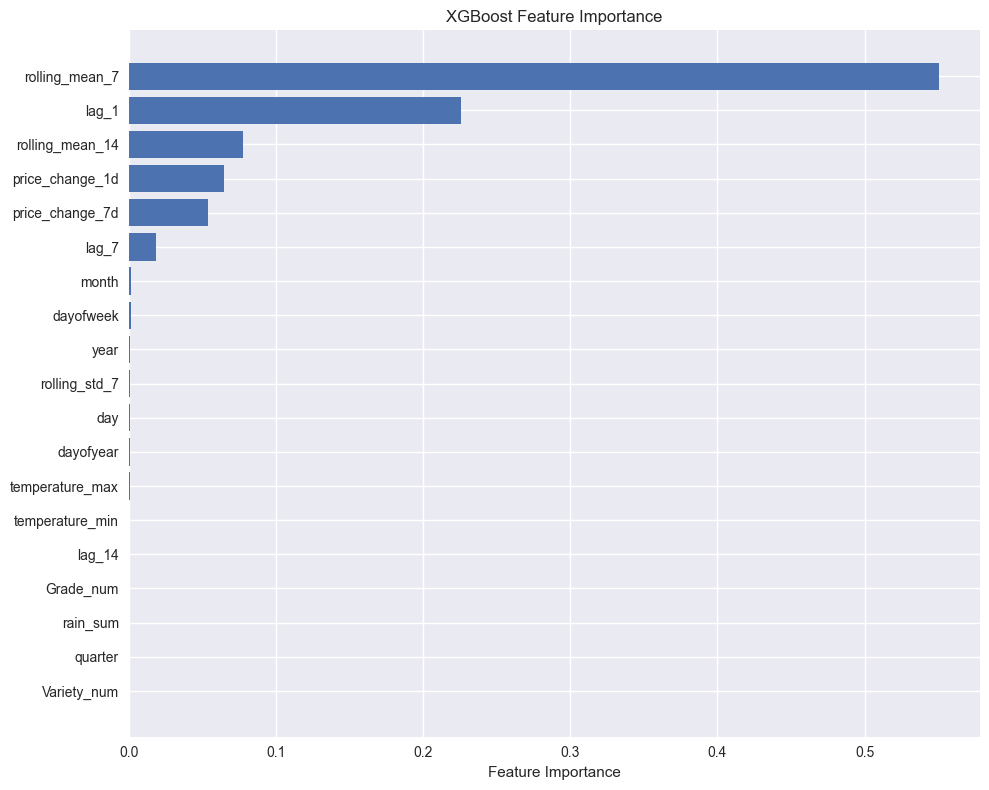


Top 5 features: ['rolling_mean_7', 'lag_1', 'rolling_mean_14', 'price_change_1d', 'price_change_7d']


In [ ]:
# Step 6: Analyze feature importance
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Show which features contribute most
top_5_features = importance_df.head(5)['feature'].tolist()
print(f"\nTop 5 features: {top_5_features}")

In [ ]:
# Step 7: Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid (keeping it simple to avoid long runtime)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Create XGBoost model for grid search
xgb_grid = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.8
)

# Perform grid search with 3-fold CV
print("Starting hyperparameter tuning...")
print("This might take a few minutes...")

grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert back to positive MAE

print(f"\nBest parameters: {best_params}")
print(f"Best CV MAE: {best_score:.2f}")

# Train best model
best_xgb_model = grid_search.best_estimator_

Starting hyperparameter tuning...
This might take a few minutes...
Fitting 3 folds for each of 81 candidates, totalling 243 fits



Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'subsample': 1.0}
Best CV MAE: 185.55


In [ ]:
# Step 8: Evaluate best model
# Make predictions with best model
y_pred_best_train = best_xgb_model.predict(X_train)
y_pred_best_test = best_xgb_model.predict(X_test)

# Calculate metrics for best model
best_train_mae = mean_absolute_error(y_train, y_pred_best_train)
best_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_best_train))

best_test_mae = mean_absolute_error(y_test, y_pred_best_test)
best_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_test))
best_test_mape = np.mean(np.abs((y_test - y_pred_best_test) / y_test)) * 100

print("\n=== FINAL RESULTS COMPARISON ===")
print("\n📊 Basic XGBoost:")
print(f"   Test MAE: {test_mae:.2f}")
print(f"   Test RMSE: {test_rmse:.2f}")
print(f"   Test MAPE: {test_mape:.2f}%")

print("\n🎯 Tuned XGBoost:")
print(f"   Test MAE: {best_test_mae:.2f}")
print(f"   Test RMSE: {best_test_rmse:.2f}")
print(f"   Test MAPE: {best_test_mape:.2f}%")

# Calculate improvement
mae_improvement = ((test_mae - best_test_mae) / test_mae) * 100
print(f"\n📈 Improvement: {mae_improvement:.1f}% better MAE")

# Print best parameters for reference
print(f"\n🔧 Best Parameters:")
for param, value in best_params.items():
    print(f"   {param}: {value}")


=== FINAL RESULTS COMPARISON ===

📊 Basic XGBoost:
   Test MAE: 118.84
   Test RMSE: 260.04
   Test MAPE: 1.04%

🎯 Tuned XGBoost:
   Test MAE: 109.28
   Test RMSE: 248.66
   Test MAPE: 0.98%

📈 Improvement: 8.0% better MAE

🔧 Best Parameters:
   learning_rate: 0.2
   max_depth: 4
   n_estimators: 300
   subsample: 1.0


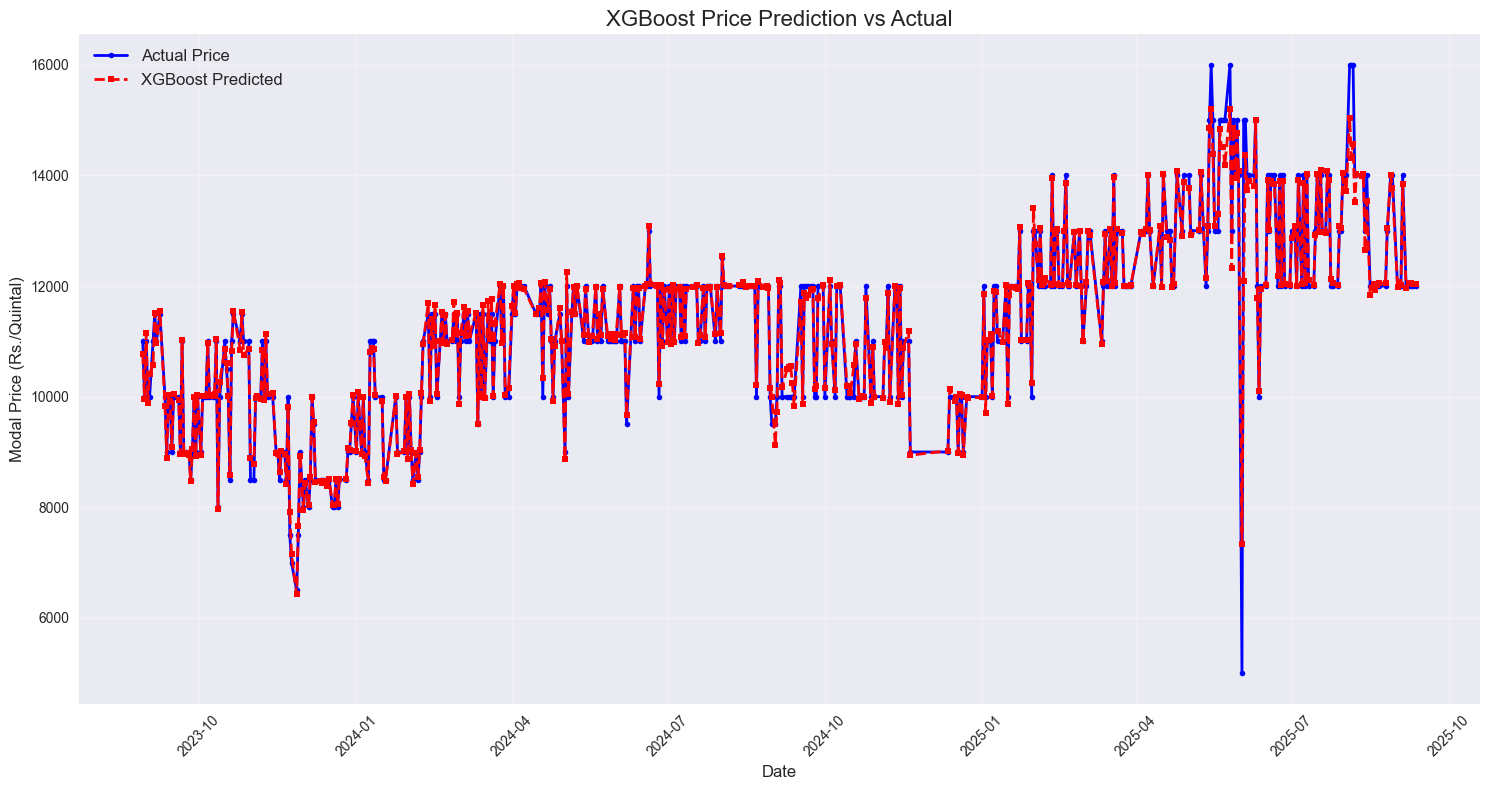

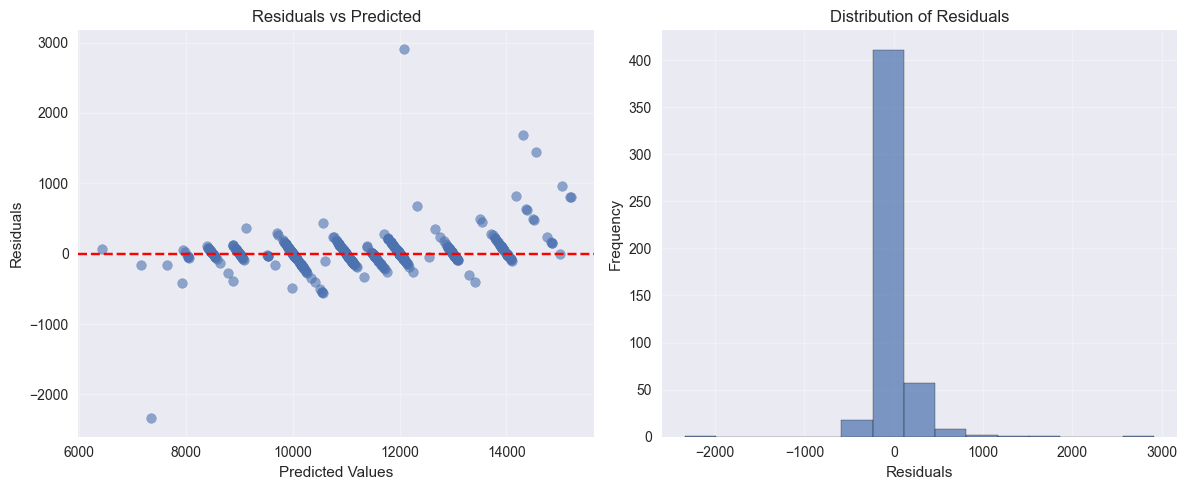

📊 Visualization completed!
Mean residual: 13.35
Std residual: 248.30


In [ ]:
# Step 9: Visualize predictions
import matplotlib.pyplot as plt

# Get dates for test period
test_dates = df_clean['Date'].iloc[train_size:].values

# Create visualization
plt.figure(figsize=(15, 8))

# Plot actual vs predicted
plt.plot(test_dates, y_test.values, 'b-', label='Actual Price', linewidth=2, marker='o', markersize=4)
plt.plot(test_dates, y_pred_best_test, 'r--', label='XGBoost Predicted', linewidth=2, marker='s', markersize=4)

plt.title('XGBoost Price Prediction vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate residuals
residuals = y_test.values - y_pred_best_test

# Plot residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_best_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualization completed!")
print(f"Mean residual: {np.mean(residuals):.2f}")
print(f"Std residual: {np.std(residuals):.2f}")

In [ ]:
# Step 10: Make future predictions (if you have future weather data)
# This is similar to your Prophet approach but adapted for XGBoost

def create_future_features(last_known_price, last_known_features, future_weather, n_days=7):
    """
    Create features for future prediction
    """
    future_features = []
    current_price = last_known_price
    
    for i in range(n_days):
        # Get weather for this day
        weather_row = future_weather.iloc[i]
        
        # Create feature row
        feature_row = {}
        
        # Weather features
        if 'temperature_max' in features:
            feature_row['temperature_max'] = weather_row['temperature_max']
        if 'temperature_min' in features:
            feature_row['temperature_min'] = weather_row['temperature_min']
        if 'rain_sum' in features:
            feature_row['rain_sum'] = weather_row['rain_sum']
        
        # Time features (you'll need to calculate based on the future date)
        future_date = weather_row['ds'] if 'ds' in weather_row else pd.Timestamp.now() + pd.Timedelta(days=i)
        if 'year' in features:
            feature_row['year'] = future_date.year
        if 'month' in features:
            feature_row['month'] = future_date.month
        if 'day' in features:
            feature_row['day'] = future_date.day
        if 'dayofweek' in features:
            feature_row['dayofweek'] = future_date.dayofweek
        if 'dayofyear' in features:
            feature_row['dayofyear'] = future_date.dayofyear
        if 'quarter' in features:
            feature_row['quarter'] = future_date.quarter
        
        # Lag features (use last known or predicted values)
        if 'lag_1' in features:
            feature_row['lag_1'] = current_price
        if 'lag_7' in features:
            feature_row['lag_7'] = last_known_features['lag_7'] if i == 0 else current_price
        if 'lag_14' in features:
            feature_row['lag_14'] = last_known_features['lag_14']
        
        # Rolling features (simplified - use last known values)
        if 'rolling_mean_7' in features:
            feature_row['rolling_mean_7'] = last_known_features['rolling_mean_7']
        if 'rolling_std_7' in features:
            feature_row['rolling_std_7'] = last_known_features['rolling_std_7']
        if 'rolling_mean_14' in features:
            feature_row['rolling_mean_14'] = last_known_features['rolling_mean_14']
        
        # Grade and variety (use last known)
        if 'Grade_num' in features:
            feature_row['Grade_num'] = last_known_features['Grade_num']
        if 'Variety_num' in features:
            feature_row['Variety_num'] = last_known_features['Variety_num']
        
        # Price change features (set to 0 for simplicity)
        if 'price_change_1d' in features:
            feature_row['price_change_1d'] = 0.0
        if 'price_change_7d' in features:
            feature_row['price_change_7d'] = 0.0
        
        future_features.append(feature_row)
        
        # Update current_price for next iteration (predict and use)
        if i < n_days - 1:  # Don't predict on last iteration
            feature_df = pd.DataFrame([feature_row])
            feature_df = feature_df.reindex(columns=features, fill_value=0)
            current_price = best_xgb_model.predict(feature_df)[0]
    
    return pd.DataFrame(future_features)

# print("Future prediction function created!")
# print("\nTo use this for future predictions:")
# print("1. Get your future weather data")
# print("2. Call: future_df = create_future_features(last_price, last_features, weather_future)")
# print("3. Make predictions: future_preds = best_xgb_model.predict(future_df)")
print("\n✅ XGBoost implementation complete!")


✅ XGBoost implementation complete!


In [ ]:
# XGBoost 7-Day Price Prediction

# Step 1: Get the last known values from your training data
last_row_index = len(df_clean) - 1
last_known_price = df_clean[target].iloc[last_row_index]
last_known_date = df_clean['Date'].iloc[last_row_index]

# Get last known feature values
last_known_features = {}
for feature in features:
    last_known_features[feature] = df_clean[feature].iloc[last_row_index]

print(f"Last known price: ₹{last_known_price:.2f}")
print(f"Last known date: {last_known_date}")
print(f"Using {len(features)} features for prediction")

# Step 2: Create future weather data (you can modify this with real future weather data)
# For now, I'll create sample future weather based on recent averages
recent_weather = df_clean[['temperature_max', 'temperature_min', 'rain_sum']].tail(7).mean()

future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=7, freq='D')
future_weather = pd.DataFrame({
    'ds': future_dates,
    'temperature_max': [recent_weather['temperature_max']] * 7,
    'temperature_min': [recent_weather['temperature_min']] * 7, 
    'rain_sum': [recent_weather['rain_sum']] * 7
})

print(f"\nFuture weather forecast:")
print(future_weather)

Last known price: ₹12000.00
Last known date: 2025-09-12 00:00:00
Using 19 features for prediction

Future weather forecast:
          ds  temperature_max  temperature_min  rain_sum
0 2025-09-13        27.175286        19.175286  2.542857
1 2025-09-14        27.175286        19.175286  2.542857
2 2025-09-15        27.175286        19.175286  2.542857
3 2025-09-16        27.175286        19.175286  2.542857
4 2025-09-17        27.175286        19.175286  2.542857
5 2025-09-18        27.175286        19.175286  2.542857
6 2025-09-19        27.175286        19.175286  2.542857


In [ ]:
# Step 3: Create future features and make predictions
def make_7day_predictions(model, last_price, last_features, future_weather, features_list):
    """
    Make 7-day predictions using XGBoost
    """
    predictions = []
    current_price = last_price
    
    for i in range(7):
        # Get weather for this day
        weather_row = future_weather.iloc[i]
        future_date = weather_row['ds']
        
        # Create feature row
        feature_row = {}
        
        # Weather features
        if 'temperature_max' in features_list:
            feature_row['temperature_max'] = weather_row['temperature_max']
        if 'temperature_min' in features_list:
            feature_row['temperature_min'] = weather_row['temperature_min']
        if 'rain_sum' in features_list:
            feature_row['rain_sum'] = weather_row['rain_sum']
        
        # Time features
        if 'year' in features_list:
            feature_row['year'] = future_date.year
        if 'month' in features_list:
            feature_row['month'] = future_date.month
        if 'day' in features_list:
            feature_row['day'] = future_date.day
        if 'dayofweek' in features_list:
            feature_row['dayofweek'] = future_date.dayofweek
        if 'dayofyear' in features_list:
            feature_row['dayofyear'] = future_date.dayofyear
        if 'quarter' in features_list:
            feature_row['quarter'] = future_date.quarter
        
        # Lag features - use current_price as lag_1 for next prediction
        if 'lag_1' in features_list:
            feature_row['lag_1'] = current_price
        if 'lag_7' in features_list:
            if i == 0:
                feature_row['lag_7'] = last_features.get('lag_7', current_price)
            else:
                # Use price from 7 days ago if available, otherwise current
                feature_row['lag_7'] = predictions[0] if i >= 1 else current_price
        if 'lag_14' in features_list:
            feature_row['lag_14'] = last_features.get('lag_14', current_price)
        
        # Rolling features (use last known values - in real scenario, you'd update these)
        if 'rolling_mean_7' in features_list:
            feature_row['rolling_mean_7'] = last_features.get('rolling_mean_7', current_price)
        if 'rolling_std_7' in features_list:
            feature_row['rolling_std_7'] = last_features.get('rolling_std_7', 0)
        if 'rolling_mean_14' in features_list:
            feature_row['rolling_mean_14'] = last_features.get('rolling_mean_14', current_price)
        
        # Categorical features
        if 'Grade_num' in features_list:
            feature_row['Grade_num'] = last_features.get('Grade_num', 0)
        if 'Variety_num' in features_list:
            feature_row['Variety_num'] = last_features.get('Variety_num', 0)
        
        # Price change features (set to small values)
        if 'price_change_1d' in features_list:
            feature_row['price_change_1d'] = 0.01  # 1% change assumption
        if 'price_change_7d' in features_list:
            feature_row['price_change_7d'] = 0.02  # 2% change assumption
        
        # Create DataFrame with correct feature order
        feature_df = pd.DataFrame([feature_row])
        feature_df = feature_df.reindex(columns=features_list, fill_value=0)
        
        # Make prediction
        prediction = model.predict(feature_df)[0]
        predictions.append(prediction)
        
        # Update current_price for next iteration
        current_price = prediction
        
        print(f"Day {i+1} ({future_date.strftime('%Y-%m-%d')}): ₹{prediction:.2f}")
    
    return predictions, future_dates

# Make the predictions
print("🔮 Making 7-day predictions with XGBoost:")
print("=" * 50)


print(f"Last known price: ₹{last_known_price:.2f}")
print(f"Last known date: {last_known_date}")

predictions_7day, prediction_dates = make_7day_predictions(
    best_xgb_model, 
    last_known_price, 
    last_known_features, 
    future_weather, 
    features
)

🔮 Making 7-day predictions with XGBoost:
Last known price: ₹12000.00
Last known date: 2025-09-12 00:00:00
Day 1 (2025-09-13): ₹12026.07
Day 2 (2025-09-14): ₹12022.52
Day 3 (2025-09-15): ₹12036.66
Day 4 (2025-09-16): ₹12024.15
Day 5 (2025-09-17): ₹12029.16
Day 6 (2025-09-18): ₹12028.40
Day 7 (2025-09-19): ₹12029.79


In [ ]:
from groq import Groq
client = Groq(api_key="")

prompt = """You are an agri-market analyst. Based on the following 7-day forecasted prices, generate market-style insights in 1–3 lines, similar to commodity reports.

Commodity: Apple
Location: Binny Mill (Bangalore, Karnataka)
Last Known Price: ₹14000 (on 2025-09-04)

Predicted Prices:
Day 1 (2025-09-05): ₹12752.03
Day 2 (2025-09-06): ₹12475.03
Day 3 (2025-09-07): ₹12290.48
Day 4 (2025-09-08): ₹12281.94
Day 5 (2025-09-09): ₹12285.97
Day 6 (2025-09-10): ₹12275.51
Day 7 (2025-09-11): ₹12275.99

Generate insights like:
“Onion prices in Lasalgaon are expected to increase by 12% in the next 5 days due to heavy rainfall (+45% vs normal) reducing supply.”
"""

response = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=[{"role":"user","content":prompt}],
    temperature=0.7,
    max_tokens=200
)

print(response.choices[0].message.content)



**Apple Prices Slump in Binny Mill (Bangalore):**

Binny Mill's apple prices are expected to decline by 8.7% over the next 7 days due to a surplus supply in the market. Prices are likely to touch ₹12275.99 by September 11, down from ₹14000 on September 4.


In [ ]:
datetime.now().date() - timedelta(days=10)

datetime.date(2025, 9, 6)

In [ ]:
merged_df.tail(10)

,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min_Price,Max_Price,Modal_Price,Date,date,Grade_num,Variety_num,temperature_max,temperature_min,precipitation_sum,rain_sum,Market_ID
2493,1241,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,14000,12000,2025-09-02,2025-09-02,0,0,25.411001,19.511000,5.5,5.5,1
2494,917,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,16000,12000,2025-09-03,2025-09-03,0,0,25.961000,19.211000,2.8,2.8,1
2495,1973,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,16000,14000,2025-09-04,2025-09-04,0,0,26.761000,19.011000,1.3,1.3,1
2496,1046,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,16000,12000,2025-09-06,2025-09-06,0,0,27.661001,19.561000,1.8,1.8,1
2497,713,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,15000,12000,2025-09-08,2025-09-08,0,0,28.111000,19.011000,1.5,1.5,1
2498,186,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,14000,12000,2025-09-09,2025-09-09,0,0,27.511000,19.411001,8.8,8.8,1
2499,568,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,16000,12000,2025-09-10,2025-09-10,0,0,26.211000,19.211000,0.4,0.4,1
2500,2481,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,16000,12000,2025-09-12,2025-09-12,0,0,28.011000,18.811000,1.2,1.2,1
2501,2459,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,16000,12000,2025-09-15,2025-09-15,0,0,NaN,NaN,NaN,0.0,1
2502,1980,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,10000,16000,13000,2025-09-16,2025-09-16,0,0,NaN,NaN,NaN,NaN,1


In [ ]:
last_row_index = len(df_clean) - 1
last_known_price = df_clean[target].iloc[last_row_index]

In [ ]:
print(last_known_price)
print(df_clean['Date'].iloc[last_row_index])

10000
2024-06-26 00:00:00


#With arrival data 


In [61]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

# Setup Open-Meteo API client with cache and retry
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Set daily weather variables
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 12.9716,
    "longitude": 77.5946,
    "start_date": "2015-09-16",
    "end_date": "2025-09-16",
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "rain_sum"],
    "timezone": "auto"
}

responses = openmeteo.weather_api(url, params=params)

# Process first location
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data
daily = response.Daily()
daily_temperature_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_min = daily.Variables(1).ValuesAsNumpy()
daily_precipitation = daily.Variables(2).ValuesAsNumpy()
daily_rain = daily.Variables(3).ValuesAsNumpy()

# ✅ Build correct date range
dates = pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s", utc=True),
    end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)

daily_data = {
    "Date": dates.tz_localize(None),  # drop UTC timezone
    "temperature_max": daily_temperature_max,
    "temperature_min": daily_temperature_min,
    "precipitation_sum": daily_precipitation,
    "rain_sum": daily_rain
}

daily_dataframe = pd.DataFrame(data=daily_data)

# Handle missing rain values → replace NaN with 0
daily_dataframe["rain_sum"] = daily_dataframe["rain_sum"].fillna(0)

daily_dataframe["Date"] = pd.to_datetime(daily_dataframe["Date"]).dt.date

print(daily_dataframe.head())
print(daily_dataframe.tail())


# Save CSV
daily_dataframe.to_csv("weather_data_delhi.csv", index=False)

Coordinates: 12.970123291015625°N 77.56363677978516°E
Elevation: 910.0 m asl
Timezone difference to GMT+0: 19800s
         Date  temperature_max  temperature_min  precipitation_sum  rain_sum
0  2015-09-15        25.786999        20.286999                2.6       2.6
1  2015-09-16        27.286999        19.837000                0.0       0.0
2  2015-09-17        26.937000        18.636999                0.0       0.0
3  2015-09-18        27.087000        19.737000                0.5       0.5
4  2015-09-19        26.587000        19.437000                2.1       2.1
            Date  temperature_max  temperature_min  precipitation_sum  \
3649  2025-09-11        27.161001        19.561001                0.4   
3650  2025-09-12        28.011000        18.811001                1.2   
3651  2025-09-13        27.761000        18.761000                0.0   
3652  2025-09-14              NaN              NaN                NaN   
3653  2025-09-15              NaN              NaN         

In [105]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
from datetime import datetime, timedelta
import urllib.parse

# ----------------------------
# 🔹 Fetch data from Agmarknet (Fixed)
# ----------------------------
def fetch_agmarknet_data(commodity_code, state_code, district_id, market_id, date_from, date_to,
                         data_type="both", commodity_name="", state_name="", district_name="", market_name=""):
    """
    data_type options:
    - "price" or 0: Price only
    - "arrival" or 1: Arrival only  
    - "both" or 2: Both price and arrival (default)
    """
    
    # Convert data_type to the correct parameter value
    if data_type == "price":
        trend_param = "0"
    elif data_type == "arrival": 
        trend_param = "1"
    else:  # "both" or 2
        trend_param = "2"
    
    base_url = "https://agmarknet.gov.in/SearchCmmMkt.aspx"
    
    # Build parameters exactly like your working URL
    params = {
        "Tx_Commodity": commodity_code,
        "Tx_State": state_code,
        "Tx_District": district_id,
        "Tx_Market": market_id,
        "DateFrom": date_from,
        "DateTo": date_to,
        "Fr_Date": date_from,
        "To_Date": date_to,
        "Tx_Trend": trend_param,  # This controls price/arrival/both
        "Tx_CommodityHead": commodity_name,
        "Tx_StateHead": state_name,
        "Tx_DistrictHead": district_name,
        "Tx_MarketHead": market_name
    }
    
    # Build the exact URL
    url = f"{base_url}?" + urllib.parse.urlencode(params)
    print(f"🔍 DEBUG: Requesting URL: {url}")
    
    # Add proper headers
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
    }

    try:
        response = requests.get(url, headers=headers, timeout=30)
        response.raise_for_status()
        
        print(f"🔍 DEBUG: Response status: {response.status_code}")
        
        # Save response for debugging
        with open("debug_response.html", "w", encoding="utf-8") as f:
            f.write(response.text)
        print("🔍 DEBUG: Response saved to debug_response.html")
        
        soup = BeautifulSoup(response.text, "html.parser")
        
        # Look for the data table - try multiple possible IDs
        table = None
        possible_table_ids = [
            "cphBody_GridPriceData", 
            "GridPriceData",
            "gvPrice", 
            "gvPriceData"
        ]
        
        for table_id in possible_table_ids:
            table = soup.find("table", {"id": table_id})
            if table:
                print(f"🔍 DEBUG: Found table with ID: {table_id}")
                break
        
        if not table:
            # Look for any table with multiple rows
            all_tables = soup.find_all("table")
            print(f"🔍 DEBUG: No table found with expected IDs. Found {len(all_tables)} total tables")
            
            for i, t in enumerate(all_tables):
                rows = t.find_all("tr")
                if len(rows) > 1:  # Has header + data rows
                    print(f"🔍 DEBUG: Using table {i} with {len(rows)} rows")
                    table = t
                    break
        
        if not table:
            return {"error": "No data table found in response", "debug": "Check debug_response.html"}

        # Extract data from table
        data = []
        headers = []
        
        # Get headers
        header_row = table.find("tr")
        if header_row:
            headers = [th.get_text(strip=True) for th in header_row.find_all(["th", "td"])]
            print(f"🔍 DEBUG: Headers found: {headers}")

        # Get data rows
        rows = table.find_all("tr")[1:]  # Skip header row
        print(f"🔍 DEBUG: Found {len(rows)} data rows")

        for i, row in enumerate(rows):
            cols = [td.get_text(strip=True) for td in row.find_all("td")]
            if cols and len(cols) == len(headers):
                row_data = dict(zip(headers, cols))
                data.append(row_data)
                
                # Print first few rows for debugging
                if i < 3:
                    print(f"🔍 DEBUG: Row {i+1}: {row_data}")

        print(f"✅ Successfully extracted {len(data)} rows")
        return data

    except requests.RequestException as e:
        return {"error": f"Request failed: {str(e)}"}
    except Exception as e:
        return {"error": f"Parsing failed: {str(e)}"}

# ----------------------------
# 🔹 Test with your exact parameters
# ----------------------------
def test_exact_match():
    """Test with the exact same parameters as your working URL"""
    
    print("=" * 60)
    print("🧪 TESTING WITH YOUR EXACT PARAMETERS")
    print("=" * 60)
    
    # Your exact date range
    date_from = "16-Sep-2015"
    date_to = "16-Sep-2025"
    
    print(f"📅 Date range: {date_from} to {date_to}")
    
    # Test 1: Get both price and arrival data (Tx_Trend=2)
    print("\n🔍 Test 1: Getting BOTH price and arrival data...")
    data_both = fetch_agmarknet_data(
        commodity_code="78",
        state_code="KK", 
        district_id="1",
        market_id="108",
        date_from=date_from,
        date_to=date_to,
        data_type="both",  # This sets Tx_Trend=2
        commodity_name="Onion",
        state_name="Karnataka",
        district_name="Bangalore", 
        market_name="Binny Mill (F&V), Bangalore"
    )
    
    if isinstance(data_both, list) and data_both:
        print(f"✅ SUCCESS: Got {len(data_both)} rows with both price and arrival data")
        print(f"📊 Columns: {list(data_both[0].keys())}")
        
        # Save the data
        with open("agmarknet_both_data.csv", "w", newline="", encoding="utf-8") as f:
            if data_both:
                writer = csv.DictWriter(f, fieldnames=data_both[0].keys())
                writer.writeheader()
                writer.writerows(data_both)
        print("💾 Data saved to agmarknet_both_data.csv")
        
    else:
        print(f"❌ FAILED: {data_both}")
    
    # # Test 2: Get arrival data only (Tx_Trend=1)
    # print("\n🔍 Test 2: Getting ARRIVAL data only...")
    # data_arrival = fetch_agmarknet_data(
    #     commodity_code="78",
    #     state_code="KK",
    #     district_id="1", 
    #     market_id="108",
    #     date_from=date_from,
    #     date_to=date_to,
    #     data_type="arrival",  # This sets Tx_Trend=1
    #     commodity_name="Apple",
    #     state_name="Karnataka",
    #     district_name="Bangalore",
    #     market_name="Binny Mill (F&V), Bangalore"
    # )
    
    # if isinstance(data_arrival, list) and data_arrival:
    #     print(f"✅ SUCCESS: Got {len(data_arrival)} rows with arrival data only")
    #     print(f"📊 Columns: {list(data_arrival[0].keys())}")
        
    #     # Save the arrival data
    #     with open("agmarknet_arrival_only.csv", "w", newline="", encoding="utf-8") as f:
    #         if data_arrival:
    #             writer = csv.DictWriter(f, fieldnames=data_arrival[0].keys())
    #             writer.writeheader() 
    #             writer.writerows(data_arrival)
    #     print("💾 Arrival data saved to agmarknet_arrival_only.csv")
        
    # else:
    #     print(f"❌ FAILED: {data_arrival}")
        
    return data_both

# ----------------------------
# 🔹 Run the test
# ----------------------------
if __name__ == "__main__":
    both_data = test_exact_match()
    
    print("\n" + "=" * 60)
    print("📋 SUMMARY")
    print("=" * 60)
    
    if isinstance(both_data, list) and both_data:
        print(f"✅ Both data: {len(both_data)} rows")
        print(f"📄 Sample row: {both_data[0]}")
    else:
        print("❌ Both data: Failed")
        
    
        
    print("\n💡 Check debug_response.html to see the actual server response")

# ----------------------------
# 🔹 Alternative: Try with longer date range
# ----------------------------
def test_longer_range():
    """Test with a longer date range if the short range doesn't work"""
    print("\n🔄 Testing with longer date range...")
    
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=30)
    
    date_from = start_date.strftime("%d-%b-%Y")
    date_to = end_date.strftime("%d-%b-%Y")
    
    return fetch_agmarknet_data(
        commodity_code="78",
        state_code="KK",
        district_id="1",
        market_id="108", 
        date_from=date_from,
        date_to=date_to,
        data_type="arrival",
        commodity_name="Tomato",
        state_name="Karnataka",
        district_name="Bangalore",
        market_name="Binny Mill (F&V), Bangalore"
    )

🧪 TESTING WITH YOUR EXACT PARAMETERS
📅 Date range: 16-Sep-2015 to 16-Sep-2025

🔍 Test 1: Getting BOTH price and arrival data...
🔍 DEBUG: Requesting URL: https://agmarknet.gov.in/SearchCmmMkt.aspx?Tx_Commodity=78&Tx_State=KK&Tx_District=1&Tx_Market=108&DateFrom=16-Sep-2015&DateTo=16-Sep-2025&Fr_Date=16-Sep-2015&To_Date=16-Sep-2025&Tx_Trend=2&Tx_CommodityHead=Onion&Tx_StateHead=Karnataka&Tx_DistrictHead=Bangalore&Tx_MarketHead=Binny+Mill+%28F%26V%29%2C+Bangalore
🔍 DEBUG: Response status: 200
🔍 DEBUG: Response saved to debug_response.html
🔍 DEBUG: No table found with expected IDs. Found 1 total tables
🔍 DEBUG: Using table 0 with 2514 rows
🔍 DEBUG: Headers found: ['State Name', 'District Name', 'Market Name', 'Variety', 'Group', 'Arrivals (Tonnes)', 'Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)', 'Reported Date', 'Grade']
🔍 DEBUG: Found 2513 data rows
🔍 DEBUG: Row 1: {'State Name': 'Karnataka', 'District Name': 'Bangalore', 'Market Name': 'Binny Mill (F&V

In [110]:
new= pd.read_csv("agmarknet_both_data.csv")
new.rename(columns={
        "Reported Date": "Date",
        "Min Price (Rs./Quintal)": "Min_Price",
        "Max Price (Rs./Quintal)": "Max_Price",
        "Modal Price (Rs./Quintal)": "Modal_Price"
    }, inplace=True)

new = new.drop([0, 1]).reset_index(drop=True)

# Convert Date column to datetime and format it as YYYY-MM-DD (or any format you want)
new["Date"] = pd.to_datetime(new["Date"], errors="coerce").dt.strftime("%Y-%m-%d")

# Final cleaned DataFrame

new = new.sort_values("Date").reset_index(drop=True)
new



,State Name,District Name,Market Name,Variety,Group,Arrivals (Tonnes),Min_Price,Max_Price,Modal_Price,Date,Grade
0,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,67.0,600,800,700,2015-09-16,FAQ
1,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,57.0,500,800,700,2015-09-18,FAQ
2,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,62.0,500,700,600,2015-09-19,FAQ
3,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,60.0,600,900,700,2015-09-21,FAQ
4,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,60.0,700,900,800,2015-09-22,FAQ
...,...,...,...,...,...,...,...,...,...,...,...
2504,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,99.0,1000,1200,1100,2025-09-10,Local
2505,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,83.0,1000,1200,1100,2025-09-11,Local
2506,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,151.0,1000,1200,1100,2025-09-12,Local
2507,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,212.0,1000,1200,1100,2025-09-15,Local


In [111]:
import pandas as pd
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read data
commodity_df = new
weather_df = pd.read_csv("weather_data_17th_sep.csv")

# Convert both date columns to datetime format
commodity_df['Date'] = pd.to_datetime(commodity_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

# Merge on Date
merged_df = pd.merge(
    commodity_df,
    weather_df,
    on="Date",   # common columne
    how="left"   # keep all commodity rows, add weather if date matches
)


# Load your existing merged data
# merged_df = pd.read_csv("merged_commodity_weather.csv")
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values("Date").reset_index(drop=True)
unique_markets = merged_df["Market Name"].unique()
print("Unique Market Names:", unique_markets)

# Create mapping {market_name: id}
market_mapping = {name: idx for idx, name in enumerate(unique_markets, start=1)}
print("\nMapping:", market_mapping)

# Map to integer column
merged_df["Market_ID"] = merged_df["Market Name"].map(market_mapping)

merged_df["Arrivals (Tonnes)"] = pd.to_numeric(merged_df["Arrivals (Tonnes)"], errors='coerce')
clean = merged_df.drop(
    columns=["State Name", "District Name", "Market Name", "Variety", "Group", "Grade"]
)
clean.to_csv("final_merged_data.csv", index=False)
print(clean.head())
print(clean.dtypes)

len(clean)



Unique Market Names: ['Binny Mill (F&V), Bangalore']

Mapping: {'Binny Mill (F&V), Bangalore': 1}
   Arrivals (Tonnes)  Min_Price  Max_Price  Modal_Price       Date  \
0               67.0        600        800          700 2015-09-16   
1               57.0        500        800          700 2015-09-18   
2               62.0        500        700          600 2015-09-19   
3               60.0        600        900          700 2015-09-21   
4               60.0        700        900          800 2015-09-22   

   temperature_max  temperature_min  precipitation_sum  rain_sum  Market_ID  
0        27.286999           19.837                0.0       0.0          1  
1        27.087000           19.737                0.5       0.5          1  
2        26.587000           19.437                2.1       2.1          1  
3        28.387000           17.437                0.0       0.0          1  
4        28.337000           17.837                0.0       0.0          1  
Arrivals (Ton

2509

In [112]:
# Step 2: Feature Engineering for XGBoost
def create_time_features(df):
    """Create time-based features from date column"""
    df = df.copy()
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['quarter'] = df['Date'].dt.quarter
    return df


# Create time features
df = create_time_features(clean)

# Create lag features (same as before)
df["lag_1"] = df["Modal_Price"].shift(1)
df["lag_7"] = df["Modal_Price"].shift(7)
df["lag_14"] = df["Modal_Price"].shift(14)  # Additional lag feature

# Create rolling features
df["rolling_mean_7"] = df["Modal_Price"].shift(1).rolling(7).mean()
df["rolling_std_7"] = df["Modal_Price"].shift(1).rolling(7).std()
df["rolling_mean_14"] = df["Modal_Price"].shift(1).rolling(14).mean()

# Create price change features
df["price_change_1d"] = df["Modal_Price"].pct_change(1)
df["price_change_7d"] = df["Modal_Price"].pct_change(7)

print("Features created successfully!")
print("New shape:", df.shape)
df.tail()

Features created successfully!
New shape: (2509, 24)


,Arrivals (Tonnes),Min_Price,Max_Price,Modal_Price,Date,temperature_max,temperature_min,precipitation_sum,rain_sum,Market_ID,...,dayofyear,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7,rolling_mean_14,price_change_1d,price_change_7d
2504,99.0,1000,1200,1100,2025-09-10,26.211000,19.211,0.4,0.4,1,...,253,3,1100.0,2600.0,3600.0,2057.142857,657.918797,2850.000000,0.0,-0.576923
2505,83.0,1000,1200,1100,2025-09-11,27.161001,19.561,0.4,0.4,1,...,254,3,1100.0,2400.0,3400.0,1842.857143,694.879229,2671.428571,0.0,-0.541667
2506,151.0,1000,1200,1100,2025-09-12,28.011000,18.811,1.2,1.2,1,...,255,3,1100.0,2400.0,3400.0,1657.142857,694.879229,2507.142857,0.0,-0.541667
2507,212.0,1000,1200,1100,2025-09-15,27.761000,18.761,0.0,0.0,1,...,258,3,1100.0,2400.0,3800.0,1471.428571,634.335047,2342.857143,0.0,-0.541667
2508,113.0,1000,1200,1100,2025-09-16,NaN,NaN,NaN,NaN,1,...,259,3,1100.0,2400.0,3800.0,1285.714286,491.353815,2150.000000,0.0,-0.541667


In [113]:
# Step 3: Define features for XGBoost
feature_columns = [
    # Weather features
    'temperature_max', 'temperature_min', 'rain_sum',
    
    # Lag features
    'lag_1', 'lag_7', 'lag_14',
    
    # Rolling features
    'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14',
    
    # Time features
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter',
    
    # Grade and Variety (if they exist)
    'Grade_num', 'Variety_num','Arrivals (Tonnes)',
    
    # Price change features
    'price_change_1d', 'price_change_7d'
]

# Check which features actually exist in your dataframe
existing_features = [col for col in feature_columns if col in df.columns]
missing_features = [col for col in feature_columns if col not in df.columns]

print("Existing features:", existing_features)
print("Missing features:", missing_features)

# Use only existing features
features = existing_features
target = 'Modal_Price'

print(f"\nUsing {len(features)} features for modeling")
print("Target variable:", target)

Existing features: ['temperature_max', 'temperature_min', 'rain_sum', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter', 'Arrivals (Tonnes)', 'price_change_1d', 'price_change_7d']
Missing features: ['Grade_num', 'Variety_num']

Using 18 features for modeling
Target variable: Modal_Price


In [114]:
# Step 4: Clean data and create train-test split
# Remove rows with NaN values
df_clean = df.dropna(subset=features + [target]).reset_index(drop=True)

print(f"Data shape after cleaning: {df_clean.shape}")
print(f"Rows dropped due to NaN: {len(df) - len(df_clean)}")

# Create features and target arrays
X = df_clean[features]
y = df_clean[target]

# Same split as Prophet (last 30 days for testing)
test_days = 500
train_size = len(df_clean) - test_days

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"\nTrain size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"Feature dimensions: {X_train.shape[1]}")

# Display feature importance overview
print(f"\nFeatures being used:")
for i, feature in enumerate(features):
    print(f"{i+1:2d}. {feature}")

Data shape after cleaning: (2494, 24)
Rows dropped due to NaN: 15

Train size: 1994
Test size: 500
Feature dimensions: 18

Features being used:
 1. temperature_max
 2. temperature_min
 3. rain_sum
 4. lag_1
 5. lag_7
 6. lag_14
 7. rolling_mean_7
 8. rolling_std_7
 9. rolling_mean_14
10. year
11. month
12. day
13. dayofweek
14. dayofyear
15. quarter
16. Arrivals (Tonnes)
17. price_change_1d
18. price_change_7d


In [115]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Step 5: Train basic XGBoost model
# Create XGBoost regressor with initial parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== XGBoost Results ===")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

print("\nModel trained successfully! ✅")

Training XGBoost model...

=== XGBoost Results ===
Train MAE: 16.64
Train RMSE: 22.32
Test MAE: 58.43
Test RMSE: 136.24
Test MAPE: 2.30%

Model trained successfully! ✅


In [116]:
from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred_test)
print(round(score,2)*100)

98.0


Top 10 Most Important Features:
            feature  importance
3             lag_1    0.601104
6    rolling_mean_7    0.289800
17  price_change_7d    0.032954
16  price_change_1d    0.028935
9              year    0.020963
8   rolling_mean_14    0.004173
4             lag_7    0.003324
0   temperature_max    0.003295
13        dayofyear    0.002844
1   temperature_min    0.002004


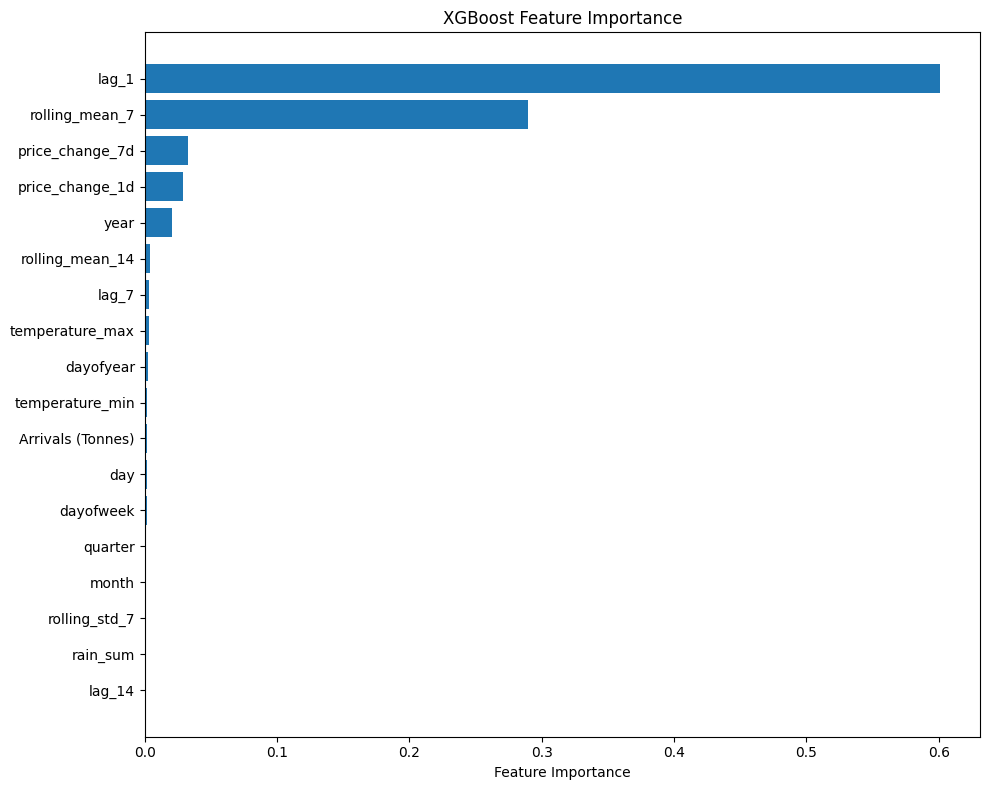


Top 5 features: ['lag_1', 'rolling_mean_7', 'price_change_7d', 'price_change_1d', 'year']


In [118]:

# Step 6: Analyze feature importance
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Show which features contribute most
top_5_features = importance_df.head(5)['feature'].tolist()
print(f"\nTop 5 features: {top_5_features}")

In [119]:
# Step 7: Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid (keeping it simple to avoid long runtime)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Create XGBoost model for grid search
xgb_grid = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.8
)

# Perform grid search with 3-fold CV
print("Starting hyperparameter tuning...")
print("This might take a few minutes...")

grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert back to positive MAE

print(f"\nBest parameters: {best_params}")
print(f"Best CV MAE: {best_score:.2f}")

# Train best model
best_xgb_model = grid_search.best_estimator_

Starting hyperparameter tuning...
This might take a few minutes...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.9}
Best CV MAE: 133.72


In [120]:
# Step 8: Evaluate best model
# Make predictions with best model
y_pred_best_train = best_xgb_model.predict(X_train)
y_pred_best_test = best_xgb_model.predict(X_test)

# Calculate metrics for best model
best_train_mae = mean_absolute_error(y_train, y_pred_best_train)
best_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_best_train))

best_test_mae = mean_absolute_error(y_test, y_pred_best_test)
best_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_test))
best_test_mape = np.mean(np.abs((y_test - y_pred_best_test) / y_test)) * 100

print("\n=== FINAL RESULTS COMPARISON ===")
print("\n📊 Basic XGBoost:")
print(f"   Test MAE: {test_mae:.2f}")
print(f"   Test RMSE: {test_rmse:.2f}")
print(f"   Test MAPE: {test_mape:.2f}%")

print("\n🎯 Tuned XGBoost:")
print(f"   Test MAE: {best_test_mae:.2f}")
print(f"   Test RMSE: {best_test_rmse:.2f}")
print(f"   Test MAPE: {best_test_mape:.2f}%")

# Calculate improvement
mae_improvement = ((test_mae - best_test_mae) / test_mae) * 100
print(f"\n📈 Improvement: {mae_improvement:.1f}% better MAE")

# Print best parameters for reference
print(f"\n🔧 Best Parameters:")
for param, value in best_params.items():
    print(f"   {param}: {value}")


=== FINAL RESULTS COMPARISON ===

📊 Basic XGBoost:
   Test MAE: 58.43
   Test RMSE: 136.24
   Test MAPE: 2.30%

🎯 Tuned XGBoost:
   Test MAE: 59.78
   Test RMSE: 124.89
   Test MAPE: 2.39%

📈 Improvement: -2.3% better MAE

🔧 Best Parameters:
   learning_rate: 0.1
   max_depth: 4
   n_estimators: 300
   subsample: 0.9


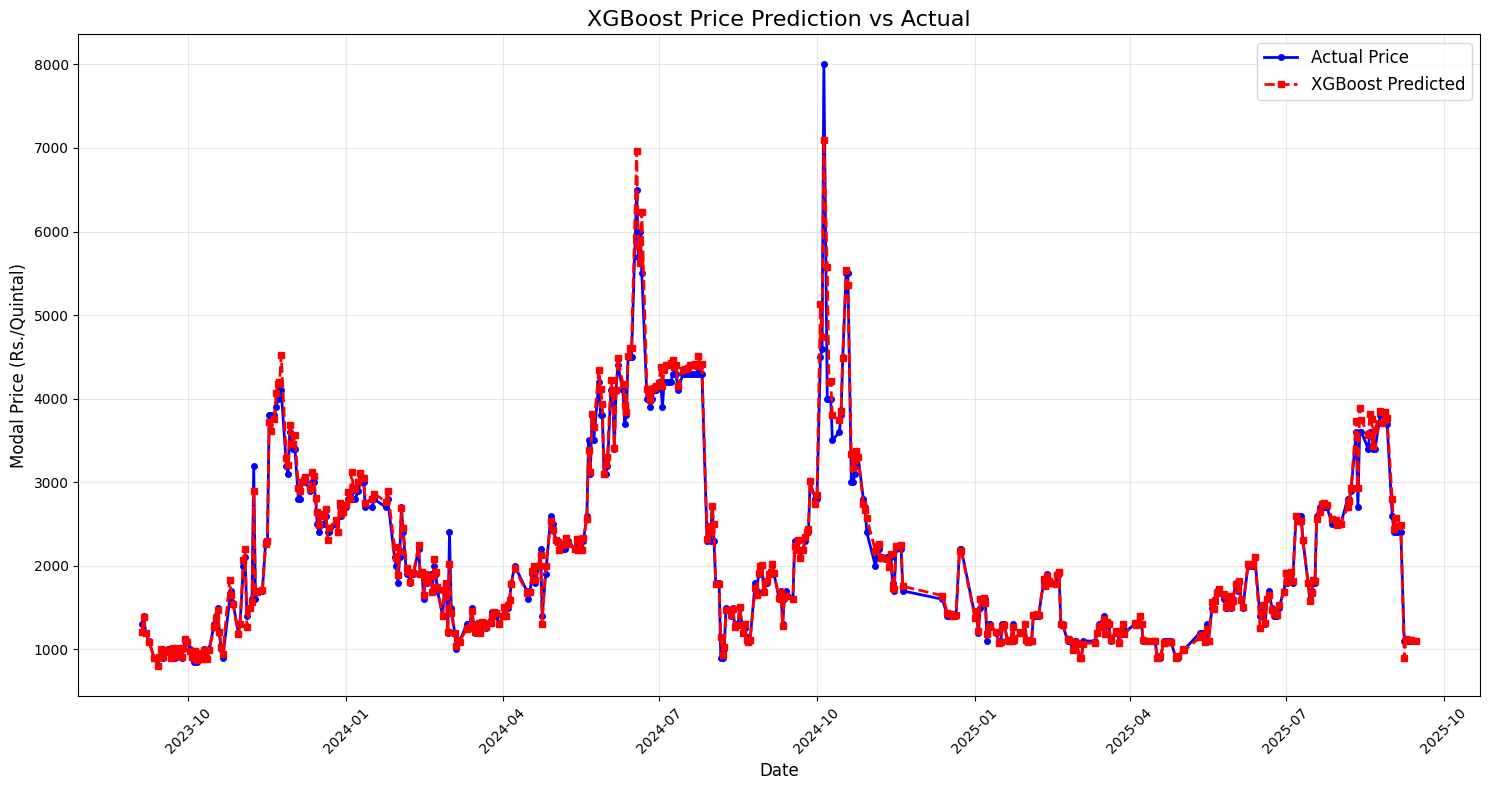

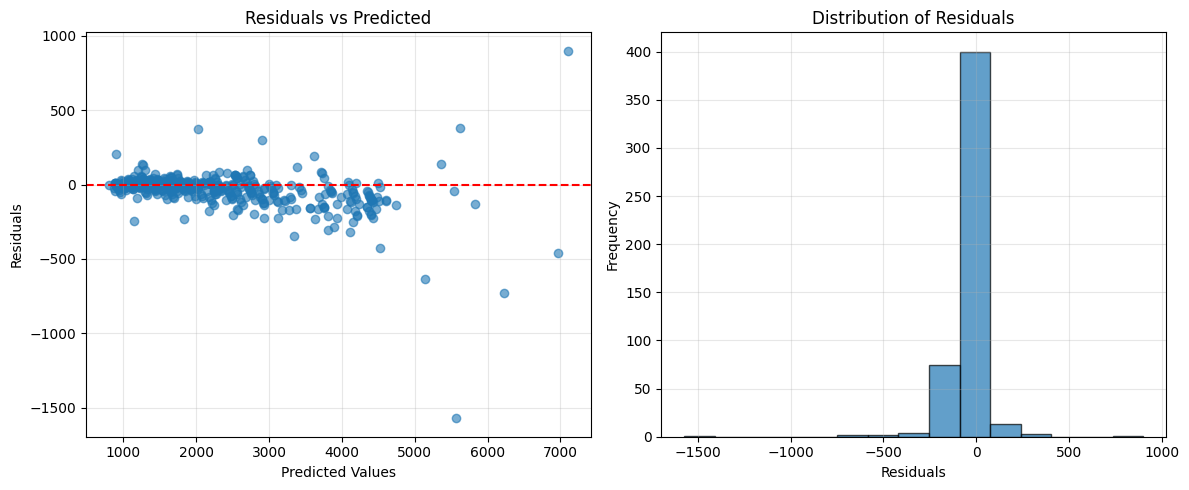

📊 Visualization completed!
Mean residual: -31.13
Std residual: 120.95


In [121]:
# Step 9: Visualize predictions
import matplotlib.pyplot as plt

# Get dates for test period
test_dates = df_clean['Date'].iloc[train_size:].values

# Create visualization
plt.figure(figsize=(15, 8))

# Plot actual vs predicted
plt.plot(test_dates, y_test.values, 'b-', label='Actual Price', linewidth=2, marker='o', markersize=4)
plt.plot(test_dates, y_pred_best_test, 'r--', label='XGBoost Predicted', linewidth=2, marker='s', markersize=4)

plt.title('XGBoost Price Prediction vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate residuals
residuals = y_test.values - y_pred_best_test

# Plot residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_best_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualization completed!")
print(f"Mean residual: {np.mean(residuals):.2f}")
print(f"Std residual: {np.std(residuals):.2f}")

In [122]:
# Step 10: Make future predictions (if you have future weather data)
# This is similar to your Prophet approach but adapted for XGBoost

def create_future_features(last_known_price, last_known_features, future_weather, n_days=7):
    """
    Create features for future prediction
    """
    future_features = []
    current_price = last_known_price
    
    for i in range(n_days):
        # Get weather for this day
        weather_row = future_weather.iloc[i]
        
        # Create feature row
        feature_row = {}
        
        # Weather features
        if 'temperature_max' in features:
            feature_row['temperature_max'] = weather_row['temperature_max']
        if 'temperature_min' in features:
            feature_row['temperature_min'] = weather_row['temperature_min']
        if 'rain_sum' in features:
            feature_row['rain_sum'] = weather_row['rain_sum']
        
        # Time features (you'll need to calculate based on the future date)
        future_date = weather_row['ds'] if 'ds' in weather_row else pd.Timestamp.now() + pd.Timedelta(days=i)
        if 'year' in features:
            feature_row['year'] = future_date.year
        if 'month' in features:
            feature_row['month'] = future_date.month
        if 'day' in features:
            feature_row['day'] = future_date.day
        if 'dayofweek' in features:
            feature_row['dayofweek'] = future_date.dayofweek
        if 'dayofyear' in features:
            feature_row['dayofyear'] = future_date.dayofyear
        if 'quarter' in features:
            feature_row['quarter'] = future_date.quarter
        
        # Lag features (use last known or predicted values)
        if 'lag_1' in features:
            feature_row['lag_1'] = current_price
        if 'lag_7' in features:
            feature_row['lag_7'] = last_known_features['lag_7'] if i == 0 else current_price
        if 'lag_14' in features:
            feature_row['lag_14'] = last_known_features['lag_14']
        
        # Rolling features (simplified - use last known values)
        if 'rolling_mean_7' in features:
            feature_row['rolling_mean_7'] = last_known_features['rolling_mean_7']
        if 'rolling_std_7' in features:
            feature_row['rolling_std_7'] = last_known_features['rolling_std_7']
        if 'rolling_mean_14' in features:
            feature_row['rolling_mean_14'] = last_known_features['rolling_mean_14']
        
        # Grade and variety (use last known)
        if 'Grade_num' in features:
            feature_row['Grade_num'] = last_known_features['Grade_num']
        if 'Variety_num' in features:
            feature_row['Variety_num'] = last_known_features['Variety_num']
        
        # Price change features (set to 0 for simplicity)
        if 'price_change_1d' in features:
            feature_row['price_change_1d'] = 0.0
        if 'price_change_7d' in features:
            feature_row['price_change_7d'] = 0.0
        
        future_features.append(feature_row)
        
        # Update current_price for next iteration (predict and use)
        if i < n_days - 1:  # Don't predict on last iteration
            feature_df = pd.DataFrame([feature_row])
            feature_df = feature_df.reindex(columns=features, fill_value=0)
            current_price = best_xgb_model.predict(feature_df)[0]
    
    return pd.DataFrame(future_features)

# print("Future prediction function created!")
# print("\nTo use this for future predictions:")
# print("1. Get your future weather data")
# print("2. Call: future_df = create_future_features(last_price, last_features, weather_future)")
# print("3. Make predictions: future_preds = best_xgb_model.predict(future_df)")
print("\n✅ XGBoost implementation complete!")


✅ XGBoost implementation complete!


In [123]:
# XGBoost 7-Day Price Prediction

# Step 1: Get the last known values from your training data
last_row_index = len(df_clean) - 1
last_known_price = df_clean[target].iloc[last_row_index]
last_known_date = df_clean['Date'].iloc[last_row_index]

# Get last known feature values
last_known_features = {}
for feature in features:
    last_known_features[feature] = df_clean[feature].iloc[last_row_index]

print(f"Last known price: ₹{last_known_price:.2f}")
print(f"Last known date: {last_known_date}")
print(f"Using {len(features)} features for prediction")

# Step 2: Create future weather data (you can modify this with real future weather data)
# For now, I'll create sample future weather based on recent averages
recent_weather = df_clean[['temperature_max', 'temperature_min', 'rain_sum']].tail(7).mean()

future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=7, freq='D')
future_weather = pd.DataFrame({
    'ds': future_dates,
    'temperature_max': [recent_weather['temperature_max']] * 7,
    'temperature_min': [recent_weather['temperature_min']] * 7, 
    'rain_sum': [recent_weather['rain_sum']] * 7
})

print(f"\nFuture weather forecast:")
print(future_weather)

Last known price: ₹1100.00
Last known date: 2025-09-15 00:00:00
Using 18 features for prediction

Future weather forecast:
          ds  temperature_max  temperature_min  rain_sum
0 2025-09-16        27.489572        19.189572  2.014286
1 2025-09-17        27.489572        19.189572  2.014286
2 2025-09-18        27.489572        19.189572  2.014286
3 2025-09-19        27.489572        19.189572  2.014286
4 2025-09-20        27.489572        19.189572  2.014286
5 2025-09-21        27.489572        19.189572  2.014286
6 2025-09-22        27.489572        19.189572  2.014286


In [124]:
# Step 3: Create future features and make predictions
def make_7day_predictions(model, last_price, last_features, future_weather, features_list):
    """
    Make 7-day predictions using XGBoost
    """
    predictions = []
    current_price = last_price
    
    for i in range(7):
        # Get weather for this day
        weather_row = future_weather.iloc[i]
        future_date = weather_row['ds']
        
        # Create feature row
        feature_row = {}
        
        # Weather features
        if 'temperature_max' in features_list:
            feature_row['temperature_max'] = weather_row['temperature_max']
        if 'temperature_min' in features_list:
            feature_row['temperature_min'] = weather_row['temperature_min']
        if 'rain_sum' in features_list:
            feature_row['rain_sum'] = weather_row['rain_sum']
        
        # Time features
        if 'year' in features_list:
            feature_row['year'] = future_date.year
        if 'month' in features_list:
            feature_row['month'] = future_date.month
        if 'day' in features_list:
            feature_row['day'] = future_date.day
        if 'dayofweek' in features_list:
            feature_row['dayofweek'] = future_date.dayofweek
        if 'dayofyear' in features_list:
            feature_row['dayofyear'] = future_date.dayofyear
        if 'quarter' in features_list:
            feature_row['quarter'] = future_date.quarter
        
        # Lag features - use current_price as lag_1 for next prediction
        if 'lag_1' in features_list:
            feature_row['lag_1'] = current_price
        if 'lag_7' in features_list:
            if i == 0:
                feature_row['lag_7'] = last_features.get('lag_7', current_price)
            else:
                # Use price from 7 days ago if available, otherwise current
                feature_row['lag_7'] = predictions[0] if i >= 1 else current_price
        if 'lag_14' in features_list:
            feature_row['lag_14'] = last_features.get('lag_14', current_price)
        
        # Rolling features (use last known values - in real scenario, you'd update these)
        if 'rolling_mean_7' in features_list:
            feature_row['rolling_mean_7'] = last_features.get('rolling_mean_7', current_price)
        if 'rolling_std_7' in features_list:
            feature_row['rolling_std_7'] = last_features.get('rolling_std_7', 0)
        if 'rolling_mean_14' in features_list:
            feature_row['rolling_mean_14'] = last_features.get('rolling_mean_14', current_price)
        
        # Categorical features
        if 'Grade_num' in features_list:
            feature_row['Grade_num'] = last_features.get('Grade_num', 0)
        if 'Variety_num' in features_list:
            feature_row['Variety_num'] = last_features.get('Variety_num', 0)
        
        # Price change features (set to small values)
        if 'price_change_1d' in features_list:
            feature_row['price_change_1d'] = 0.01  # 1% change assumption
        if 'price_change_7d' in features_list:
            feature_row['price_change_7d'] = 0.02  # 2% change assumption
        
        # Create DataFrame with correct feature order
        feature_df = pd.DataFrame([feature_row])
        feature_df = feature_df.reindex(columns=features_list, fill_value=0)
        
        # Make prediction
        prediction = model.predict(feature_df)[0]
        predictions.append(prediction)
        
        # Update current_price for next iteration
        current_price = prediction
        
        print(f"Day {i+1} ({future_date.strftime('%Y-%m-%d')}): ₹{prediction:.2f}")
    
    return predictions, future_dates

# Make the predictions
print("🔮 Making 7-day predictions with XGBoost:")
print("=" * 50)


print(f"Last known price: ₹{last_known_price:.2f}")
print(f"Last known date: {last_known_date}")

predictions_7day, prediction_dates = make_7day_predictions(
    best_xgb_model, 
    last_known_price, 
    last_known_features, 
    future_weather, 
    features
)

🔮 Making 7-day predictions with XGBoost:
Last known price: ₹1100.00
Last known date: 2025-09-15 00:00:00
Day 1 (2025-09-16): ₹1151.09
Day 2 (2025-09-17): ₹1131.75
Day 3 (2025-09-18): ₹1131.75
Day 4 (2025-09-19): ₹1138.63
Day 5 (2025-09-20): ₹1138.96
Day 6 (2025-09-21): ₹1139.55
Day 7 (2025-09-22): ₹1135.27


In [56]:
import pandas as pd
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read data
commodity_df = pd.read_csv("cleaned_agmarknet_data.csv")
weather_df = pd.read_csv("weather_data_delhi.csv")

# Convert both date columns to datetime format
commodity_df['Date'] = pd.to_datetime(commodity_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

# Merge on Date
merged_df = pd.merge(
    commodity_df,
    weather_df,
    on="Date",   # common column
    how="left"   # keep all commodity rows, add weather if date matches
)


# Load your existing merged data
merged_df = pd.read_csv("merged_commodity_weather.csv")
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values("Date").reset_index(drop=True)
unique_markets = merged_df["Market Name"].unique()
print("Unique Market Names:", unique_markets)

# Create mapping {market_name: id}
market_mapping = {name: idx for idx, name in enumerate(unique_markets, start=1)}
print("\nMapping:", market_mapping)

# Map to integer column
merged_df["Market_ID"] = merged_df["Market Name"].map(market_mapping)

merged_df["Arrivals (Tonnes)"] = pd.to_numeric(merged_df["Arrivals (Tonnes)"], errors='coerce')
clean = merged_df.drop(
    columns=["State Name", "District Name", "Market Name", "Variety", "Group", "Grade"]
)

print(clean.head())
print(clean.dtypes)


# print("Data shape:", merged_df.shape)
# print("\nColumns:", merged_df.columns.tolist())
# print("\nFirst few rows:")
# print(new_df.tail(5))

Unique Market Names: ['Binny Mill (F&V), Bangalore']

Mapping: {'Binny Mill (F&V), Bangalore': 1}
   Arrivals (Tonnes)  Min_Price  Max_Price  Modal_Price       Date  Grade_num  \
0              276.0       6000      10000         8000 2015-09-16          0   
1              166.0       6000       8000         7000 2015-09-18          0   
2              318.0       6500      10000         8500 2015-09-19          0   
3              766.0       6000       8000         7000 2015-09-21          0   
4              366.0       6500       8500         7500 2015-09-22          0   

   Variety_num  temperature_max  temperature_min  precipitation_sum  rain_sum  \
0            0        27.286999           19.837                0.0       0.0   
1            0        27.087000           19.737                0.5       0.5   
2            0        26.587000           19.437                2.1       2.1   
3            0        28.387000           17.437                0.0       0.0   
4         

In [25]:
df_clean.tail(5)

,temperature_max,temperature_min,rain_sum,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7,rolling_mean_14,year,...,day,dayofweek,dayofyear,quarter,Grade_num,Variety_num,Arrivals (Tonnes),price_change_1d,price_change_7d,Modal_Price
2460,27.661001,19.561000,1.8,14000.0,13000.0,14000.0,13000.000000,1000.000000,12642.857143,2025,...,6,5,249,3,0,0,132.0,-0.142857,-0.076923,12000
2461,28.111000,19.011000,1.5,12000.0,14000.0,12000.0,12857.142857,1069.044968,12500.000000,2025,...,8,0,251,3,0,0,287.0,0.000000,-0.142857,12000
2462,27.511000,19.411001,8.8,12000.0,14000.0,12000.0,12571.428571,975.900073,12500.000000,2025,...,9,1,252,3,0,0,77.0,0.000000,-0.142857,12000
2463,26.211000,19.211000,0.4,12000.0,12000.0,12000.0,12285.714286,755.928946,12500.000000,2025,...,10,2,253,3,0,0,133.0,0.000000,0.000000,12000
2464,28.011000,18.811000,1.2,12000.0,12000.0,12000.0,12285.714286,755.928946,12500.000000,2025,...,12,4,255,3,0,0,190.0,0.000000,0.000000,12000


In [43]:
clean.head()

,Arrivals (Tonnes),Min_Price,Max_Price,Modal_Price,Date,Grade_num,Variety_num,temperature_max,temperature_min,precipitation_sum,rain_sum,Market_ID
0,276.0,6000,10000,8000,2015-09-16,0,0,27.286999,19.837,0.0,0.0,1
1,166.0,6000,8000,7000,2015-09-18,0,0,27.087000,19.737,0.5,0.5,1
2,318.0,6500,10000,8500,2015-09-19,0,0,26.587000,19.437,2.1,2.1,1
3,766.0,6000,8000,7000,2015-09-21,0,0,28.387000,17.437,0.0,0.0,1
4,366.0,6500,8500,7500,2015-09-22,0,0,28.337000,17.837,0.0,0.0,1


In [76]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2025-09-16",
	"end_date": "2025-09-16",
	"hourly": ["temperature_2m", "rain", "precipitation"],
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_rain = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["rain"] = hourly_rain
hourly_data["precipitation"] = hourly_precipitation

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

Coordinates: 52.5483283996582°N 13.407821655273438°E
Elevation: 38.0 m asl
Timezone difference to GMT+0: 0s

Hourly data
                         date  temperature_2m  rain  precipitation
0  2025-09-16 00:00:00+00:00       15.658501   0.0            0.0
1  2025-09-16 01:00:00+00:00             NaN   NaN            NaN
2  2025-09-16 02:00:00+00:00             NaN   NaN            NaN
3  2025-09-16 03:00:00+00:00             NaN   NaN            NaN
4  2025-09-16 04:00:00+00:00             NaN   NaN            NaN
5  2025-09-16 05:00:00+00:00             NaN   NaN            NaN
6  2025-09-16 06:00:00+00:00             NaN   NaN            NaN
7  2025-09-16 07:00:00+00:00             NaN   NaN            NaN
8  2025-09-16 08:00:00+00:00             NaN   NaN            NaN
9  2025-09-16 09:00:00+00:00             NaN   NaN            NaN
10 2025-09-16 10:00:00+00:00             NaN   NaN            NaN
11 2025-09-16 11:00:00+00:00             NaN   NaN            NaN
12 2025-09-16 12:00: